# Fairy Tale Implementation

## Miscellaneous

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import os
import re

In [2]:
class bcolors:
    RED = '\033[91m'
    YELLOW = '\033[93m'
    GREEN = '\033[92m'
    BLUE = '\033[94m'
    WHITE = '\033[0m'
    
def colored_text(text, color):
    return color + text + bcolors.WHITE

## Load data

In [3]:
def pre_process_story(path, name, max_len=4012):
    global MAX_LEN
    
    df = pd.read_csv(os.path.join(path, 'annotations', name + '.csv'))
    text = open(os.path.join(path, name + '.txt')).read()
    # split into words
    words = text.split()
    # remove words that do not contain letters
    words = [word.lower() for word in words if re.search('[a-zA-Z]', word)]
    if max_len is not None and len(words) > max_len:
        print(colored_text(f'{name}: story is longer than {max_len} words ({len(words)}), skipping', bcolors.YELLOW))
        return None
    print(f'total Words: {len(words)} ({name})')
    if len(words) > MAX_LEN:
        MAX_LEN = len(words)

    if len(words) != len(df):
        print(colored_text(f'{name}: number of words ({len(words)}) and annotations ({len(df)}) do not match', bcolors.RED))
        for i, word in enumerate(words):
            if word != df['word'].values[i]:
                print(colored_text(f'word mismatch at index {i}: {word} != {df["word"].values[i]}', bcolors.YELLOW))
        return None

    sentence = []
    i = 1
    for word in words:
        sentence.append(i)
        if word[-1] in ['.', '!', '?']:
            i += 1

    names = {}
    bio_name = []
    for e, n in zip(df['entity'].values, df['name'].values):
        if e == 'O':
            bio_name.append(0)
        else:
            if n in names:
                bio_name.append(names[n])
            else:
                names[n] = len(names) + 1
                bio_name.append(names[n])

    # set words to word column to get back punctuation
    df['word'] = words
    df['sentence'] = sentence
    df['story'] = name
    df['name'] = bio_name
    df = df[['story', 'sentence', 'word', 'entity', 'name', 'alignment']]
    return df

In [4]:
entity_enc = {'O': 0, 'B': 1, 'I': 2}
alignment_enc = {'X': 0, 'neutral': 1, 'good': 2, 'bad': 3}

def encode_labels(df):
    df['entity'] = df['entity'].apply(lambda x: entity_enc[x])
    df['alignment'] = df['alignment'].apply(lambda x: alignment_enc[x])
    return df

def decode_labels(labels, encoder):
    decoder = (lambda x: list(encoder.keys())[list(encoder.values()).index(x)])
    result = [decoder (x) for x in labels]
    return result

In [5]:
def get_fairy_tales(author):
    stories = []
    for file in os.listdir(os.path.join(author, 'annotations')):
        if file.endswith('.csv'):
            name = file[:-4]
            df = pre_process_story(author, name, max_len=None)
            if df is not None:
                stories.append(df)
    return stories

def get_data():
    authors = ['grimm', 'andersen']
    stories = []
    for author in authors:
        stories.extend(get_fairy_tales(author))
    df = pd.concat(stories)
    return df

MAX_LEN = 0
df = get_data()
print(colored_text(f'maximum story length: {MAX_LEN}', bcolors.GREEN))
#df = encode_labels(df)
df

total Words: 2693 (cinderella)
total Words: 585 (deaths_messengers)
total Words: 771 (doctor_knowall)
total Words: 2634 (donkey_cabbages)
total Words: 2868 (hansel_and_gretel)
total Words: 717 (the_wolf_and_the_fox)
total Words: 1531 (the_emperors_new_clothes)
total Words: 940 (the_little_match_girl)
total Words: 4707 (the_shadow)
total Words: 856 (the_snail_and_the_rosebush)
total Words: 918 (the_wicked_prince)
total Words: 6305 (the_wild_swans)
maximum story length: 6305


,story,sentence,word,entity,name,alignment
0,cinderella,1,there,O,0,X
1,cinderella,1,was,O,0,X
2,cinderella,1,once,O,0,X
3,cinderella,1,a,B,1,neutral
4,cinderella,1,rich,I,1,neutral
...,...,...,...,...,...,...
6300,the_wild_swans,349,king,O,0,X
6301,the_wild_swans,349,had,O,0,X
6302,the_wild_swans,349,ever,O,0,X
6303,the_wild_swans,349,enjoyed,O,0,X


## Analyze data

In [6]:
#split_by = 'story'
split_by = ['sentence', 'story']

story = df.groupby(split_by)['word'].apply(list).values
tag_entity = df.groupby(split_by)['entity'].apply(list).values
tag_character = df.groupby(split_by)['name'].apply(list).values
tag_alignment = df.groupby(split_by)['alignment'].apply(list).values

In [7]:
pie = df['entity'].value_counts()
entity_prior = pie.array / pie.sum()
px.pie(names = pie.index,values= pie.values, hole = 0.5,title ='Total Count of Entity Tags')

In [8]:
pie = df['name'].value_counts()
# remove O
pie = pie[1:]
px.pie(names = pie.index,values= pie.values, hole = 0.5,title ='Total Count of Character Tags')

In [9]:
pie = df['alignment'].value_counts()
# remove O
pie = pie[1:]
px.pie(names = pie.index,values= pie.values, hole = 0.5,title ='Total Count of Alignment Tags')

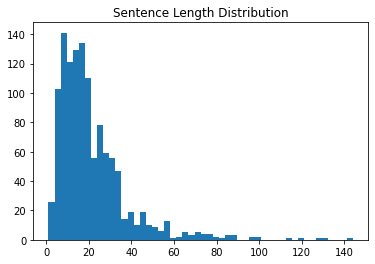

In [10]:
# sentence length
sentence_lengths = [len(s) for s in story]
plt.hist(sentence_lengths, bins=50)
plt.title('Sentence Length Distribution')
plt.show()

## Pre-processing

In [11]:
from transformers import LongformerTokenizer, TFLongformerModel
from transformers import BertTokenizer, TFBertModel, TFBertForTokenClassification
from transformers import GPT2Tokenizer, TFGPT2Model
import tensorflow as tf
from tqdm import tqdm

from sklearn import preprocessing
from sklearn.model_selection import train_test_split


C:\Users\ayden\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [12]:
model_type = 'bert'

if model_type == 'bert':
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    backbone = TFBertModel.from_pretrained('bert-base-uncased')
    #model = TFBertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=3, id2label={0: 'O', 1: 'B', 2: 'I'}, label2id={'O': 0, 'B': 1, 'I': 2})
elif model_type == 'longformer':
    tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')
    backbone = TFLongformerModel.from_pretrained('allenai/longformer-base-4096')
elif model_type == 'gpt2':
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    backbone = TFGPT2Model.from_pretrained('gpt2')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [13]:
def tokenize(data, max_len):
    input_ids = list()
    attention_mask = list()
    for i in tqdm(range(len(data))):
        encoded = tokenizer.encode_plus(data[i],
                                        add_special_tokens = True,
                                        max_length = max_len,
                                        is_split_into_words=True,
                                        return_attention_mask=True,
                                        padding = 'max_length',
                                        truncation=True, return_tensors = 'np')
                        
        
        input_ids.append(encoded['input_ids'])
        attention_mask.append(encoded['attention_mask'])
    return np.vstack(input_ids),np.vstack(attention_mask)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(story, tag_entity, random_state=42, test_size=0.1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1081,), (121,), (1081,), (121,))

In [15]:
if model_type != 'longformer':
    # max sentence length (is under 512)
    #max_len = max([len(x) for x in story])
    max_len = 40
else:
    max_len = 4096

if model_type == 'gpt2':
    tokenizer.pad_token = tokenizer.eos_token
    
input_ids, attention_mask = tokenize(X_train, max_len = max_len)
val_input_ids, val_attention_mask = tokenize(X_test, max_len = max_len)

100%|██████████| 121/121 [00:00<00:00, 1317.08it/s]


In [16]:
print(input_ids.shape, attention_mask.shape, val_input_ids.shape, val_attention_mask.shape)

(1081, 40) (1081, 40) (121, 40) (121, 40)


In [17]:
def fit_labels_to_tokenizer(tokens, labels, original, masking_value=-100):
    new_labels = []
    i = 0

    if model_type == 'gpt2':
        for token in tokens:
            if token[0] == 'Ġ'and original[i].startswith(token[1:]):
                new_labels.append(labels[i])
                i += 1
            elif i > 0 and token in original[i-1] and token not in [',', ';', '.', '!', '?']:
                if labels[i-1][0] == 'B':
                    new_labels.append("I" + labels[i-1][1:])
                else:
                    new_labels.append(labels[i-1])
            else:
                new_labels.append('O')

    else:
        for token in tokens:
            if token.startswith("##"):
                if labels[i-1][0] == 'B':
                    new_labels.append("I" + labels[i-1][1:])
                else:
                    new_labels.append(labels[i-1])
            elif token.startswith("[") and token.endswith("]"):
                new_labels.append(masking_value)
            elif i < len(original) and original[i].startswith(token):
                new_labels.append(labels[i])
                i += 1
            else:
                new_labels.append('O')

    return new_labels


def encode_labels(input_ids, labels, data, label_enc, masking_value=-100, separate_masking=False):
    global tokenizer
    new_labels = []
    for t, l, d in zip(input_ids, labels, data):
        tokens = tokenizer.convert_ids_to_tokens(t)
        fitted = fit_labels_to_tokenizer(tokens, l, d, masking_value)
        new_label = np.zeros((len(fitted), len(label_enc)))
        for i, label in enumerate(fitted):
            if separate_masking and label == masking_value:
                new_label[i, :] = masking_value
            else:
                new_label[i, label_enc[label]] = 1
        new_labels.append(new_label)
    return np.array(new_labels)

label_enc = {'O': 0, 'B': 1, 'I': 2}
labels = encode_labels(input_ids, y_train, X_train, label_enc, masking_value='O')
val_labels = encode_labels(val_input_ids, y_test, X_test, label_enc, masking_value='O')

output_size = labels.shape[-1]

print(input_ids.shape, attention_mask.shape, labels.shape)

(1081, 40) (1081, 40) (1081, 40, 3)


In [18]:
# remove all training data with only O labels
mask = np.all(labels == [1,0,0], axis=(1, 2))
input_ids_min = input_ids[~mask]
attention_mask_min = attention_mask[~mask]
labels_min = labels[~mask]
print(input_ids_min.shape, attention_mask_min.shape, labels_min.shape)

# remove all validation data with only O labels
mask = np.all(val_labels == [1,0,0], axis=(1, 2))
val_input_ids_min = val_input_ids[~mask]
val_attention_mask_min = val_attention_mask[~mask]
val_labels_min = val_labels[~mask]
print(val_input_ids_min.shape, val_attention_mask_min.shape, val_labels_min.shape)


(476, 40) (476, 40) (476, 40, 3)
(46, 40) (46, 40) (46, 40, 3)


In [19]:
labels_pie = np.argmax(labels, axis=-1)
labels_pie = labels_pie.reshape(-1)
labels_pie = pd.Series(labels_pie)
labels_pie = labels_pie.map({0: 'O', 1: 'B', 2: 'I'})
labels_pie = labels_pie.value_counts()
px.pie(names = labels_pie.index,values= labels_pie.values, hole = 0.5,title ='Total Count of Labels')

In [20]:
labels_pie = np.argmax(labels_min, axis=-1)
labels_pie = labels_pie.reshape(-1)
labels_pie = pd.Series(labels_pie)
labels_pie = labels_pie.map({0: 'O', 1: 'B', 2: 'I'})
labels_pie = labels_pie.value_counts()
px.pie(names = labels_pie.index,values= labels_pie.values, hole = 0.5,title ='Total Count of Labels')

## Model

### Custom Keras functions

In [21]:
from keras import backend as K

def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy

    Variables:
        weights: numpy array of shape (C,) where C is the number of classes

    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """

    weights = K.variable(weights)

    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss

    return loss

### Create model

In [22]:
def initializeBias(shape, dtype):
    '''Returns an initialization for either the beta oder bias parameter directly before the
       final activation. It makes the network (at start) give the
       optimal probabilities without considering the input.'''
    beta = -np.log((1 / entity_prior) - 1)
    beta_tensor = tf.constant(beta)
    beta_tensor = tf.broadcast_to(beta, shape)
    return tf.cast(beta_tensor, dtype=dtype)

In [23]:
def create_model(backbone, max_len, output_size=3):

    tokens = tf.keras.layers.Input(shape=(max_len,), name = 'tokens', dtype=tf.int32)
    attention = tf.keras.layers.Input(shape=(max_len,), name = 'attention', dtype=tf.int32)
    
    x = backbone(tokens, attention_mask=attention)
    x = x[0]

    #x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dense(output_size, dtype='float32')(x)
    #x = tf.keras.layers.BatchNormalization(beta_initializer=initializeBias,
    #                                       gamma_initializer='zeros')(x)
    x = tf.keras.layers.Activation('softmax')(x)
    
    
    model = tf.keras.Model(inputs=[tokens,attention], outputs=x)
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),
                  #loss = [tf.keras.losses.CategoricalCrossentropy()],
                  loss = [weighted_categorical_crossentropy(np.array([0.1, 2, 2]))],
                  metrics = [tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model


backbone.trainable = False
model = create_model(backbone, max_len, 3)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 5e-5),
              loss = [tf.keras.losses.CategoricalCrossentropy()],
              metrics = [tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 tokens (InputLayer)            [(None, 40)]         0           []                               
                                                                                                  
 attention (InputLayer)         [(None, 40)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['tokens[0][0]',                 
                                thPoolingAndCrossAt               'attention[0][0]']              
                                tentions(last_hidde                                               
                                n_state=(None, 40,                                            

In [24]:
# set bert layer to non-trainable
# model = TFBertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=3, id2label={0: 'OO', 1: 'B', 2: 'I'}, label2id={'OO': 0, 'B': 1, 'I': 2})
# model.layers[0].trainable = False
# model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 5e-5),
#               loss = [tf.keras.losses.CategoricalCrossentropy()],
#               metrics = [tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
# model.summary()
# model.config

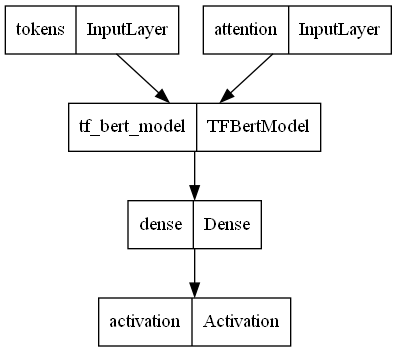

In [25]:
tf.keras.utils.plot_model(model)

## Training

In [26]:
use_min = True
epochs = 20
batch_size = 32

if use_min:
    history = model.fit([input_ids_min, attention_mask_min], labels_min,
                    validation_data = ([val_input_ids_min, val_attention_mask_min], val_labels_min),
                    epochs = epochs, batch_size = batch_size, verbose = True)
else:
    history = model.fit([input_ids, attention_mask], labels,
                        validation_data = ([val_input_ids, val_attention_mask], val_labels),
                        epochs = epochs, batch_size = batch_size, verbose = True)

Epoch 1/20
15/15 [==============================] - 11s 219ms/step - loss: 0.8907 - categorical_accuracy: 0.5863 - precision_1: 0.6550 - recall_1: 0.3721 - val_loss: 0.8541 - val_categorical_accuracy: 0.6288 - val_precision_1: 0.6967 - val_recall_1: 0.4370
Epoch 2/20
15/15 [==============================] - 1s 60ms/step - loss: 0.8176 - categorical_accuracy: 0.6612 - precision_1: 0.7420 - recall_1: 0.4603 - val_loss: 0.7868 - val_categorical_accuracy: 0.6995 - val_precision_1: 0.7603 - val_recall_1: 0.5239
Epoch 3/20
15/15 [==============================] - 1s 58ms/step - loss: 0.7548 - categorical_accuracy: 0.7243 - precision_1: 0.7965 - recall_1: 0.5436 - val_loss: 0.7298 - val_categorical_accuracy: 0.7495 - val_precision_1: 0.8045 - val_recall_1: 0.5995
Epoch 4/20
15/15 [==============================] - 1s 58ms/step - loss: 0.7070 - categorical_accuracy: 0.7659 - precision_1: 0.8331 - recall_1: 0.6136 - val_loss: 0.6817 - val_categorical_accuracy: 0.7788 - val_precision_1: 0.8313 -

## Results

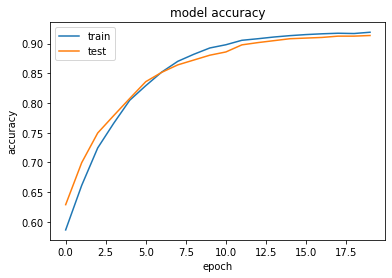

In [27]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

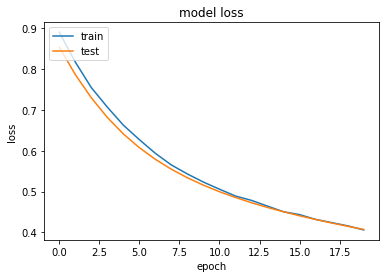

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

precision:  0.5416310505983851
recall:  0.3444759191638734
f1:  0.35016686747248826


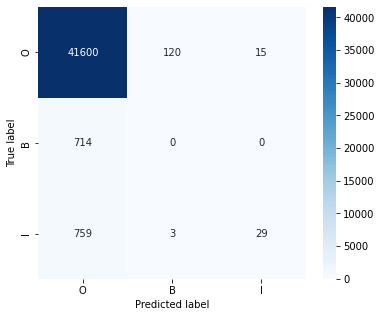

precision:  0.43380320619126583
recall:  0.33633113812461496
f1:  0.33525225843834217


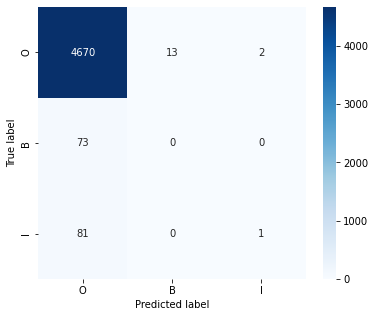

In [29]:
import sklearn.metrics as metrics
import seaborn as sn

def get_metrics(input_ids, attention_mask, labels):
    y_pred = model.predict([input_ids, attention_mask], verbose=0)
    if type(y_pred) == np.ndarray:
        y_pred = np.argmax(y_pred, axis=2).flatten()
    else:
        y_pred = np.argmax(y_pred.logits, axis=2).flatten()
    y_true = np.argmax(labels, axis=2).flatten()


    precision = metrics.precision_score(y_true, y_pred, average='macro')
    recall = metrics.recall_score(y_true, y_pred, average='macro')
    f1 = metrics.f1_score(y_true, y_pred, average='macro')

    print('precision: ', precision)
    print('recall: ', recall)
    print('f1: ', f1)

    # plot confusion matrix with matplotlib
    cm = metrics.confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index = [i for i in "OBI"],
                            columns = [i for i in "OBI"])
    plt.figure(figsize = (6,5))
    sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

get_metrics(input_ids, attention_mask, labels)
get_metrics(val_input_ids, val_attention_mask, val_labels)

### Output visualization (does not work with custom Keras model)

In [30]:
def custom_pipeline(text, model, labels):
    input_ids, attention_mask = tokenize([text], max_len=max_len)
    ner_results = model.predict([input_ids, attention_mask], verbose=0)
    ner_results = np.argmax(ner_results, axis=2).flatten()
    ner_results = [labels[i] for i in ner_results]
    words = text.split()
    string = ""
    for r, w in zip(ner_results, words):
        if r == "B":
            string += "\033[93m" + w + " "
        elif r == "I":
            string += "\033[92m" + w + " "
        else:
            string += "\033[0m" + w + " "
    return string

# print B as yellow and I as green
def visualize_test(text, labels=None):
    string = custom_pipeline(text, model, {0: 'O', 1: 'B', 2: 'I'})
    
    if labels is not None:
        orig = ""
        words = text.split()
        for i in range(len(words)):
            if labels[i] == "B":
                orig += "\033[93m" + words[i] + " "
            elif labels[i] == "I":
                orig += "\033[92m" + words[i] + " "
            else:
                orig += "\033[0m" + words[i] + " "
        print(orig)
              
    print(string)

for i in range(10):
    print("--------------------")
    example = " ".join(X_train[i])
    visualize_test(example, y_train[i])

--------------------


100%|██████████| 1/1 [00:00<00:00, 1973.79it/s]

he slept with the windows to his balcony open, and as the breeze blew his curtain aside he fancied that a marvelous radiance came from the balcony across the street. 
he slept with the windows to his balcony open, and as the breeze blew his curtain aside he fancied that a marvelous radiance came from the balcony across the street. 
--------------------



100%|██████████| 1/1 [00:00<00:00, 2003.01it/s]


she called elisa, made her undress, and told her to enter the bath. 
she called elisa, made her undress, and told her to enter the bath. 
--------------------


100%|██████████| 1/1 [00:00<00:00, 1001.51it/s]


but how am i to manage them?" the huntsman then said that he was to give three beatings and one meal daily to the old donkey, and that was the witch; one beating and three meals to the younger one, which was the servant-girl; and to the youngest, which was the maiden, no beatings and three meals, for he could not bring himself to have the maiden beaten. 
but how am i to manage them?" the huntsman then said that he was to give three beatings and one meal daily to the old donkey, and that was the witch; one beating and three meals to the younger one, 
--------------------


100%|██████████| 1/1 [00:00<00:00, 2003.97it/s]


the kitchen among the cinders. 
the kitchen among the cinders. 
--------------------


100%|██████████| 1/1 [00:00<00:00, 1997.29it/s]


its peaks were capped with sparkling ice, and in the middle rose a castle that was a mile long, with one bold colonnade perched upon another. 
its peaks were capped with sparkling ice, and in the middle rose a castle that was a mile long, with one bold colonnade perched upon another. 
--------------------


100%|██████████| 1/1 [00:00<00:00, 993.68it/s]


for instance, she immediately saw that the newcomer was a very different sort of person from all the others. 
for instance, she immediately saw that the newcomer was a very different sort of person from all the others. 
--------------------


100%|██████████| 1/1 [00:00<00:00, 2001.10it/s]


the shadow made a wry face. 
the shadow made a wry face. 
--------------------


100%|██████████| 1/1 [00:00<00:00, 2000.14it/s]


"did you ever hear such innocent prattle?" said its father. 
"did you ever hear such innocent prattle?" said its father. 
--------------------


100%|██████████| 1/1 [00:00<00:00, 2000.14it/s]


it actually hurt his eyes, but that was because he had opened them too wide in his sudden awakening. 
it actually hurt his eyes, but that was because he had opened them too wide in his sudden awakening. 
--------------------


100%|██████████| 1/1 [00:00<00:00, 2004.93it/s]

then the sun touched the rim of the sea. 
then the sun touched the rim of the sea. 
